## Text classification using Neural Networks

The goal of this notebook is to learn to use Neural Networks for text classification.

In this notebook, we will:
- Train a shallow model with learning embeddings
- Download pre-trained embeddings from Glove
- Use these pre-trained embeddings

## The BBC topic classification dataset

The BBC provides some benchmark topic classification datasets in English at: http://mlg.ucd.ie/datasets/bbc.html.

The raw text (encoded with the latin-1 character encoding) of the news can be downloaded as a ZIP archive:

In [1]:
import os
import os.path as op
import zipfile
from urllib.request import urlretrieve

BBC_DATASET_URL = "http://mlg.ucd.ie/files/datasets/bbc-fulltext.zip"
zip_filename = BBC_DATASET_URL.rsplit('/', 1)[1]
BBC_DATASET_FOLDER = 'bbc'
if not op.exists(zip_filename):
    print("Downloading %s to %s..." % (BBC_DATASET_URL, zip_filename))
    urlretrieve(BBC_DATASET_URL, zip_filename)

if not op.exists(BBC_DATASET_FOLDER):
    with zipfile.ZipFile(zip_filename, 'r') as f:
        print("Extracting contents of %s..." % zip_filename)
        f.extractall('.')

Extracting contents of bbc-fulltext.zip...


Each of the five folders contains text files from one of the five topics:

In [2]:
target_names = sorted(folder for folder in os.listdir(BBC_DATASET_FOLDER)
                      if op.isdir(op.join(BBC_DATASET_FOLDER, folder)))
target_names

['business', 'entertainment', 'politics', 'sport', 'tech']

In [3]:
# Example of a file in the "business" category
with open(op.join(BBC_DATASET_FOLDER, 'business', '001.txt'), 'rb') as f:
    print(f.read().decode('latin-1')[:500] + '...')

Ad sales boost Time Warner profit

Quarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (Â£600m) for the three months to December, from $639m year-earlier.

The firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.

Time ...


Let's randomly partition the text files in a training and test set while recording the target category of each file as an integer:

In [4]:
import numpy as np
from sklearn.model_selection import train_test_split

target = []
filenames = []
for target_id, target_name in enumerate(target_names):
    class_path = op.join(BBC_DATASET_FOLDER, target_name) # e.g. 'bbc/business'
    for filename in sorted(os.listdir(class_path)):
        filenames.append(op.join(class_path, filename))
        target.append(target_id)

target = np.asarray(target, dtype=np.int32)
target_train, target_test, filenames_train, filenames_test = train_test_split(
    target, filenames, test_size=200, random_state=0)

What we now have is pairs of target labels (which category the document belongs to) and filenames (where the document is stored on disk):

In [5]:
target_train[:5], filenames_train[:5]

(array([0, 1, 3, 4, 3], dtype=int32),
 ['bbc/business/475.txt',
  'bbc/entertainment/152.txt',
  'bbc/sport/127.txt',
  'bbc/tech/095.txt',
  'bbc/sport/464.txt'])

In [6]:
size_in_bytes = sum([len(open(fn, 'rb').read()) for fn in filenames_train])
print("Training set size: %0.3f MB" % (size_in_bytes / 1e6))

Training set size: 4.582 MB


This dataset is small so we can load everything into memory right now (which simplifies our code later). If we had substantially more data, we would need to use a `tf.data.Dataset` to stream it from disk in batches during training.

In [7]:
texts_train = [open(fn, 'rb').read().decode('latin-1') for fn in filenames_train]
texts_test = [open(fn, 'rb').read().decode('latin-1') for fn in filenames_test]

## A first baseline model

For simple topic classification problems, one should always try a simple method first. Let's try using a `CountVectorizer` followed by `LogisticRegression` as a baseline. What this will do is:

- Convert the text documents to a matrix of token counts (each row is a document, each column is a word, each cell is the count of the word in the document)
- Train a logistic regression model on this matrix

It's a very efficient method and should give us a strong baseline to compare our deep learning method against.

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

# Understanding what the CountVectorizer does
vectorizer = CountVectorizer(max_features=2000) # only keep the 2000 most frequent words
X_train = vectorizer.fit_transform(texts_train)

# Compare the content of the first document with the vocabulary
print("Start of the first document:")
print(texts_train[0][0:100] + '...')
print('----------')
print("Sampling of vocabulary counts in the document:")
for word, count in zip(vectorizer.get_feature_names_out()[200:210], X_train.toarray()[0][200:210]):
    print(word, count)

Start of the first document:
Watchdog probes Vivendi bond sale

French stock market regulator AMF has filed complaints against me...
----------
Sampling of vocabulary counts in the document:
bank 2
bankruptcy 0
banks 0
barcelona 0
based 0
basic 0
basis 1
bath 0
battle 0
bbc 0


In [9]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline


text_classifier = make_pipeline(
    CountVectorizer(max_features=2000),
    LogisticRegression(),
)

In [10]:
%time _ = text_classifier.fit(texts_train, target_train)

CPU times: user 992 ms, sys: 1.16 s, total: 2.16 s
Wall time: 683 ms


/opt/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


You may get a warning above that "lbfgs failed to converge". This means that the optimization algorithm did not reach the desired precision. This is not a big deal here, as we are not looking for the best possible accuracy, but just a baseline. We can check the accuracy of this model on the test set:

In [11]:
text_classifier.score(texts_test, target_test)

0.955

Approximately 95 percent testing accuracy on a very simple baseline. It's quite unlikely that we can significantly beat that baseline with a more complex deep learning based model. This is simply not a complex task - we wouldn't expect to see this level of performance from a simple model on a real-world text classification problem. Let's move on, and see how well we can do with a simple neural network.

### Preprocessing text for the (supervised) CBOW model

We will implement a simple classification model in Keras. Raw text requires (sometimes a lot of) preprocessing.

The following cells uses Keras to preprocess text:
- using a tokenizer. This converts the texts into sequences of indices representing the `20000` most frequent words
- sequences have different lengths, so we pad them (add 0s at the end until the sequence is of length `1000`). For example, if we were padding to three words, and we had a sequence of just "dog", we would pad it to "[\<dog token\>,0,0]".
- we convert the output classes as 1-hot encodings

In [18]:
#from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf
Tokenizer = tf.keras.preprocessing.text.Tokenizer 

MAX_NB_WORDS = 20000

# vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, char_level=False)
tokenizer.fit_on_texts(texts_train)
sequences = tokenizer.texts_to_sequences(texts_train)
sequences_test = tokenizer.texts_to_sequences(texts_test)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
print(f'Example of word_index: {list(word_index.items())[:5]}')

Found 30995 unique tokens.
Example of word_index: [('the', 1), ('to', 2), ('of', 3), ('and', 4), ('a', 5)]


Tokenized sequences are converted to list of token ids (with an integer code). We can convert them back to text to see what they now look like:

In [19]:
index_to_word = dict((i, w) for w, i in tokenizer.word_index.items())

In [20]:
print(f'Original text:          {texts_train[0].split(" ")[0:4]}')
print(f'Tokenized text:         {sequences[0][0:4]}')
print(f'Converted back to text: {[index_to_word.get(i, "UNK") for i in sequences[0][0:4]]}')

Original text:          ['Watchdog', 'probes', 'Vivendi', 'bond']
Tokenized text:         [1857, 9454, 5251, 1973]
Converted back to text: ['watchdog', 'probes', 'vivendi', 'bond']


Let's have a closer look at the tokenized sequences:

In [21]:
seq_lens = [len(s) for s in sequences]
print("average length: %0.1f" % np.mean(seq_lens))
print("max length: %d" % max(seq_lens))

average length: 382.6
max length: 4355


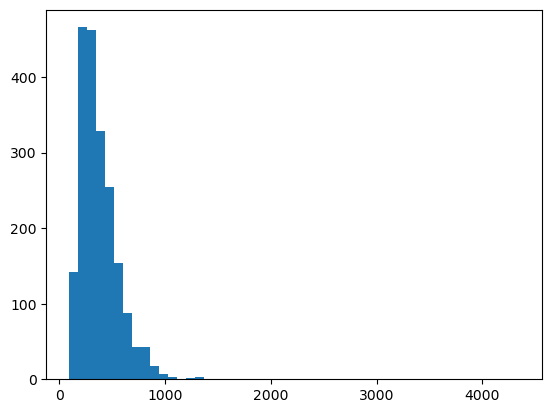

In [22]:
import matplotlib.pyplot as plt

plt.hist(seq_lens, bins=50);

We can see that while we do have sequences up to 4355 words long, the vast majority of sequences are less than 1000 words long. We can use this information to truncate or pad all the sequences to 1000 symbols to build the training set. This will simplify our model and speed up training.

In [24]:
#from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
pad_sequences = tf.keras.preprocessing.sequence.pad_sequences


MAX_SEQUENCE_LENGTH = 1000

# Make all sequences exactly 1000 words long
x_train = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', x_train.shape)
print('Shape of data test tensor:', x_test.shape)

Shape of data tensor: (2025, 1000)
Shape of data test tensor: (200, 1000)


In [25]:
from keras.utils import to_categorical

y_train = to_categorical(target_train)
print('Shape of label tensor:', y_train.shape)

Shape of label tensor: (2025, 5)


### A simple supervised CBOW model in Keras

The following computes a very simple model, as described in [fastText](https://github.com/facebookresearch/fastText):

<img src="images/fasttext.svg" style="width: 600px;" />

- Build an embedding layer mapping each word to a vector representation
- Compute the vector representation of all words in each sequence and average them
- Add a dense layer to output 5 classes

In [26]:
from keras.layers import Dense, GlobalAveragePooling1D, Embedding
from keras.models import Sequential
from keras.optimizers import Adam

EMBEDDING_DIM = 50
N_CLASSES = len(target_names) 

model = Sequential([
    Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH, trainable=True), # Just like we've seen in previous labs
    GlobalAveragePooling1D(), # This layer averages the embeddings of all words in the sequence
    Dense(N_CLASSES, activation='softmax') # This layer outputs a probability distribution over the 5 classes
])

model.compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.01),
    metrics=['accuracy']
)

/opt/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [27]:
model.fit(x_train, y_train, validation_split=0.1,
          epochs=10, batch_size=32)

Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2986 - loss: 1.5770 - val_accuracy: 0.6108 - val_loss: 1.2168
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6318 - loss: 1.1045 - val_accuracy: 0.5369 - val_loss: 1.2628
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7138 - loss: 0.7556 - val_accuracy: 0.8818 - val_loss: 0.4571
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8728 - loss: 0.4207 - val_accuracy: 0.8621 - val_loss: 0.3653
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9248 - loss: 0.2618 - val_accuracy: 0.9409 - val_loss: 0.2149
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9625 - loss: 0.1695 - val_accuracy: 0.9803 - val_loss: 0.1233
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9868 - loss: 0.0930 - val_accuracy: 0.9803 - val_loss: 0.1056
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9784 - loss: 0.0893 - val_accuracy: 0.9458 - val_loss:

**Exercise**

- Evaluate the model on the test set
- Identify an example of a mis-classified document and display the text of the document

In [32]:
output_test = model(x_test)
predicted_classes = np.argmax(output_test, axis=-1)

# Your code here
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(target_test, predicted_classes)
print(f'Accuracy: {accuracy}')

misclassified_idx = np.where(target_test != predicted_classes)[0][0]
all_missclassified = np.where(target_test != predicted_classes)[0]

print(f'Number of misclassified documents: {len(all_missclassified)}')
print(f'Misclassified document: {texts_test[misclassified_idx]}')
print(f'Predicted class: {target_names[predicted_classes[misclassified_idx]]}')
print(f'Actual class: {target_names[target_test[misclassified_idx]]}')


Accuracy: 0.965
Number of misclassified documents: 7
Misclassified document: Salary scandal in Cameroon

Cameroon says widespread corruption in its finance ministry has cost it 1bn CFA francs ($2m; Â£1m) a month.

About 500 officials are accused of either awarding themselves extra money or claiming salaries for "non-existent" workers. Prime Minister Ephraim Inoni, who vowed to tackle corruption when he came to office last year, said those found guilty would face tough punishments. The scam is believed to have begun in 1994.

The prime minister's office said the alleged fraud was uncovered during an investigation into the payroll at the ministry. In certain cases, staff are said to have lied about their rank and delayed their retirement in order to boost their earnings. The prime minister's office said auditors had found "irregularities in the career structure of certain civil servants". It added that the staff in question "appear to have received unearned salaries, boosting the payroll

### Building more complex models

**Exercise**
- Copy the previous model, and add more complexity to it. You can try adding more layers, or using a different type of layer (e.g. LSTM, Conv1D, etc.)
- Some examples of what you could do:
    - Add a LSTM layer before the dense layer ([LSTM documentation](https://keras.io/layers/recurrent/#lstm))
    - Add a Conv1D layer after the embedding layer ([Conv1D documentation](https://keras.io/layers/convolutional/#conv1d))
    - Add more dense layers

In [39]:
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Embedding, LSTM
from keras.models import Sequential

model = Sequential([
    # Your code here
    Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH, trainable=True),
    Conv1D(128, 5, activation='relu'),
    MaxPooling1D(5),
    Conv1D(128, 5, activation='relu'),
    MaxPooling1D(5),
    #Conv1D(128, 5, activation='relu'),
    #MaxPooling1D(35),
    LSTM(128),
    Flatten(),
    #Dense(5, activation='relu'),
    Dense(5, activation='softmax'),
])

model.compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.01),
    metrics=['accuracy']
)

In [40]:
model.fit(x_train, y_train, validation_split=0.1,
          epochs=15, batch_size=32)

output_test = model(x_test)
test_casses = np.argmax(output_test, axis=-1)
print("Test accuracy:", np.mean(test_casses == target_test))

Epoch 1/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - accuracy: 0.3128 - loss: 1.5070 - val_accuracy: 0.6552 - val_loss: 0.9320
Epoch 2/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - accuracy: 0.7068 - loss: 0.7517 - val_accuracy: 0.8276 - val_loss: 0.5005
Epoch 3/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.9281 - loss: 0.2335 - val_accuracy: 0.8670 - val_loss: 0.4171
Epoch 4/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - accuracy: 0.9869 - loss: 0.0629 - val_accuracy: 0.8818 - val_loss: 0.2985
Epoch 5/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - accuracy: 0.9893 - loss: 0.0373 - val_accuracy: 0.9113 - val_loss: 0.3108
Epoch 6/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.9988 - loss: 0.0082 - val_accuracy: 0.9261 - val_loss: 0.3031
Epoch 7/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - accuracy: 0.9945 - loss: 0.0144 - val_accuracy: 0.9212 - val_loss: 0.2942
Epoch 8/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - accuracy: 0.9971 - loss: 0.0085 - val_accuracy: 0.9163 - v

### Loading pre-trained embeddings

The file `glove100K.100d.txt` is an extract of [Glove](http://nlp.stanford.edu/projects/glove/) Vectors, that were trained on English Wikipedia and the Gigaword 5 corpus. They differ from word2vec in the way the vectors are trained, but the idea is the same: each word is represented as a vector of `100` numbers.

We extracted the `100 000` most frequent words for you, and the code below downloads them.

In [41]:
# Get pretrained Glove Word2Vec
URL_REPRESENTATIONS = "https://github.com/m2dsupsdlclass/lectures-labs/releases/download/0.3/glove100k.100d.zip"
ZIP_REPRESENTATIONS = "glove100k.100d.zip"
FILE_REPRESENTATIONS = "glove100K.100d.txt"

if not op.exists(ZIP_REPRESENTATIONS):
    print('Downloading from %s to %s...' % (URL_REPRESENTATIONS, ZIP_REPRESENTATIONS))
    urlretrieve(URL_REPRESENTATIONS, './' + ZIP_REPRESENTATIONS)

if not op.exists(FILE_REPRESENTATIONS):
    print("extracting %s..." % ZIP_REPRESENTATIONS)
    myzip = zipfile.ZipFile(ZIP_REPRESENTATIONS)
    myzip.extractall()

extracting glove100k.100d.zip...


In [42]:
embeddings_index = {}
embeddings_vectors = []
with open('glove100K.100d.txt', 'rb') as f:
    word_idx = 0
    for line in f:
        values = line.decode('utf-8').split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = word_idx
        embeddings_vectors.append(vector)
        word_idx = word_idx + 1

inv_index = {v: k for k, v in embeddings_index.items()}
print("found %d different words in the file" % word_idx)

found 100000 different words in the file


In [43]:
# Stack all embeddings in a large numpy array
glove_embeddings = np.vstack(embeddings_vectors)
glove_norms = np.linalg.norm(glove_embeddings, axis=-1, keepdims=True)
glove_embeddings_normed = glove_embeddings / glove_norms
print(glove_embeddings.shape)

(100000, 100)


In [44]:
def get_emb(word):
    idx = embeddings_index.get(word)
    if idx is None:
        return None
    else:
        return glove_embeddings[idx]

    
def get_normed_emb(word):
    idx = embeddings_index.get(word)
    if idx is None:
        return None
    else:
        return glove_embeddings_normed[idx]

In [45]:
get_emb("computer")

array([-1.6298e-01,  3.0141e-01,  5.7978e-01,  6.6548e-02,  4.5835e-01,
       -1.5329e-01,  4.3258e-01, -8.9215e-01,  5.7747e-01,  3.6375e-01,
        5.6524e-01, -5.6281e-01,  3.5659e-01, -3.6096e-01, -9.9662e-02,
        5.2753e-01,  3.8839e-01,  9.6185e-01,  1.8841e-01,  3.0741e-01,
       -8.7842e-01, -3.2442e-01,  1.1202e+00,  7.5126e-02,  4.2661e-01,
       -6.0651e-01, -1.3893e-01,  4.7862e-02, -4.5158e-01,  9.3723e-02,
        1.7463e-01,  1.0962e+00, -1.0044e+00,  6.3889e-02,  3.8002e-01,
        2.1109e-01, -6.6247e-01, -4.0736e-01,  8.9442e-01, -6.0974e-01,
       -1.8577e-01, -1.9913e-01, -6.9226e-01, -3.1806e-01, -7.8565e-01,
        2.3831e-01,  1.2992e-01,  8.7721e-02,  4.3205e-01, -2.2662e-01,
        3.1549e-01, -3.1748e-01, -2.4632e-03,  1.6615e-01,  4.2358e-01,
       -1.8087e+00, -3.6699e-01,  2.3949e-01,  2.5458e+00,  3.6111e-01,
        3.9486e-02,  4.8607e-01, -3.6974e-01,  5.7282e-02, -4.9317e-01,
        2.2765e-01,  7.9966e-01,  2.1428e-01,  6.9811e-01,  1.12

### Finding most similar words

Here we define a function to find the most similar words to a given word. The similarity is computed using the cosine similarity between the word embeddings. It can also accept multiple words, and it will take the average of the embeddings of the words to find the most similar words.

In [46]:
def most_similar(words, topn=10):
    query_emb = 0
    # If we have a list of words instead of one word
    # (bonus question)
    if type(words) == list:
        for word in words:
            query_emb += get_emb(word)
    else:
        query_emb = get_emb(words)

    query_emb = query_emb / np.linalg.norm(query_emb)

    # Large numpy vector with all cosine similarities
    # between emb and all other words
    cosines = np.dot(glove_embeddings_normed, query_emb)

    # topn most similar indexes corresponding to cosines
    idxs = np.argsort(cosines)[::-1][:topn]

    # pretty return with word and similarity
    return [(inv_index[idx], cosines[idx]) for idx in idxs]

In [47]:
most_similar("cpu")

[('cpu', 0.99999994),
 ('processor', 0.77934384),
 ('cpus', 0.7651844),
 ('microprocessor', 0.7360635),
 ('processors', 0.6734816),
 ('motherboard', 0.6675774),
 ('x86', 0.66559225),
 ('pentium', 0.6475851),
 ('gpu', 0.6448883),
 ('i/o', 0.6352353)]

In [48]:
most_similar("nvidia")

[('nvidia', 1.0000001),
 ('geforce', 0.7025037),
 ('gpu', 0.6787486),
 ('ati', 0.67037094),
 ('chipset', 0.63813114),
 ('gpus', 0.63303804),
 ('amd', 0.6098825),
 ('chipsets', 0.6023345),
 ('tesla', 0.58550215),
 ('intel', 0.5631714)]

In [49]:
most_similar("1")

[('1', 1.0),
 ('2', 0.97136056),
 ('3', 0.9551015),
 ('4', 0.93552566),
 ('5', 0.9143884),
 ('6', 0.90160364),
 ('8', 0.8834145),
 ('7', 0.8745429),
 ('9', 0.84709466),
 ('10', 0.8159793)]

In [50]:
# bonus: sum of two word embeddings
most_similar(["toronto", "leaf"])

[('leaf', 0.78682536),
 ('toronto', 0.7771216),
 ('maple', 0.7656235),
 ('red', 0.6574253),
 ('buffalo', 0.64467776),
 ('leafs', 0.63587487),
 ('montreal', 0.63387597),
 ('boston', 0.626379),
 ('seattle', 0.6214547),
 ('cleveland', 0.6207881)]

### Displaying vectors with  t-SNE

In [51]:
from sklearn.manifold import TSNE

word_emb_tsne = TSNE(perplexity=30).fit_transform(glove_embeddings_normed[:1000])

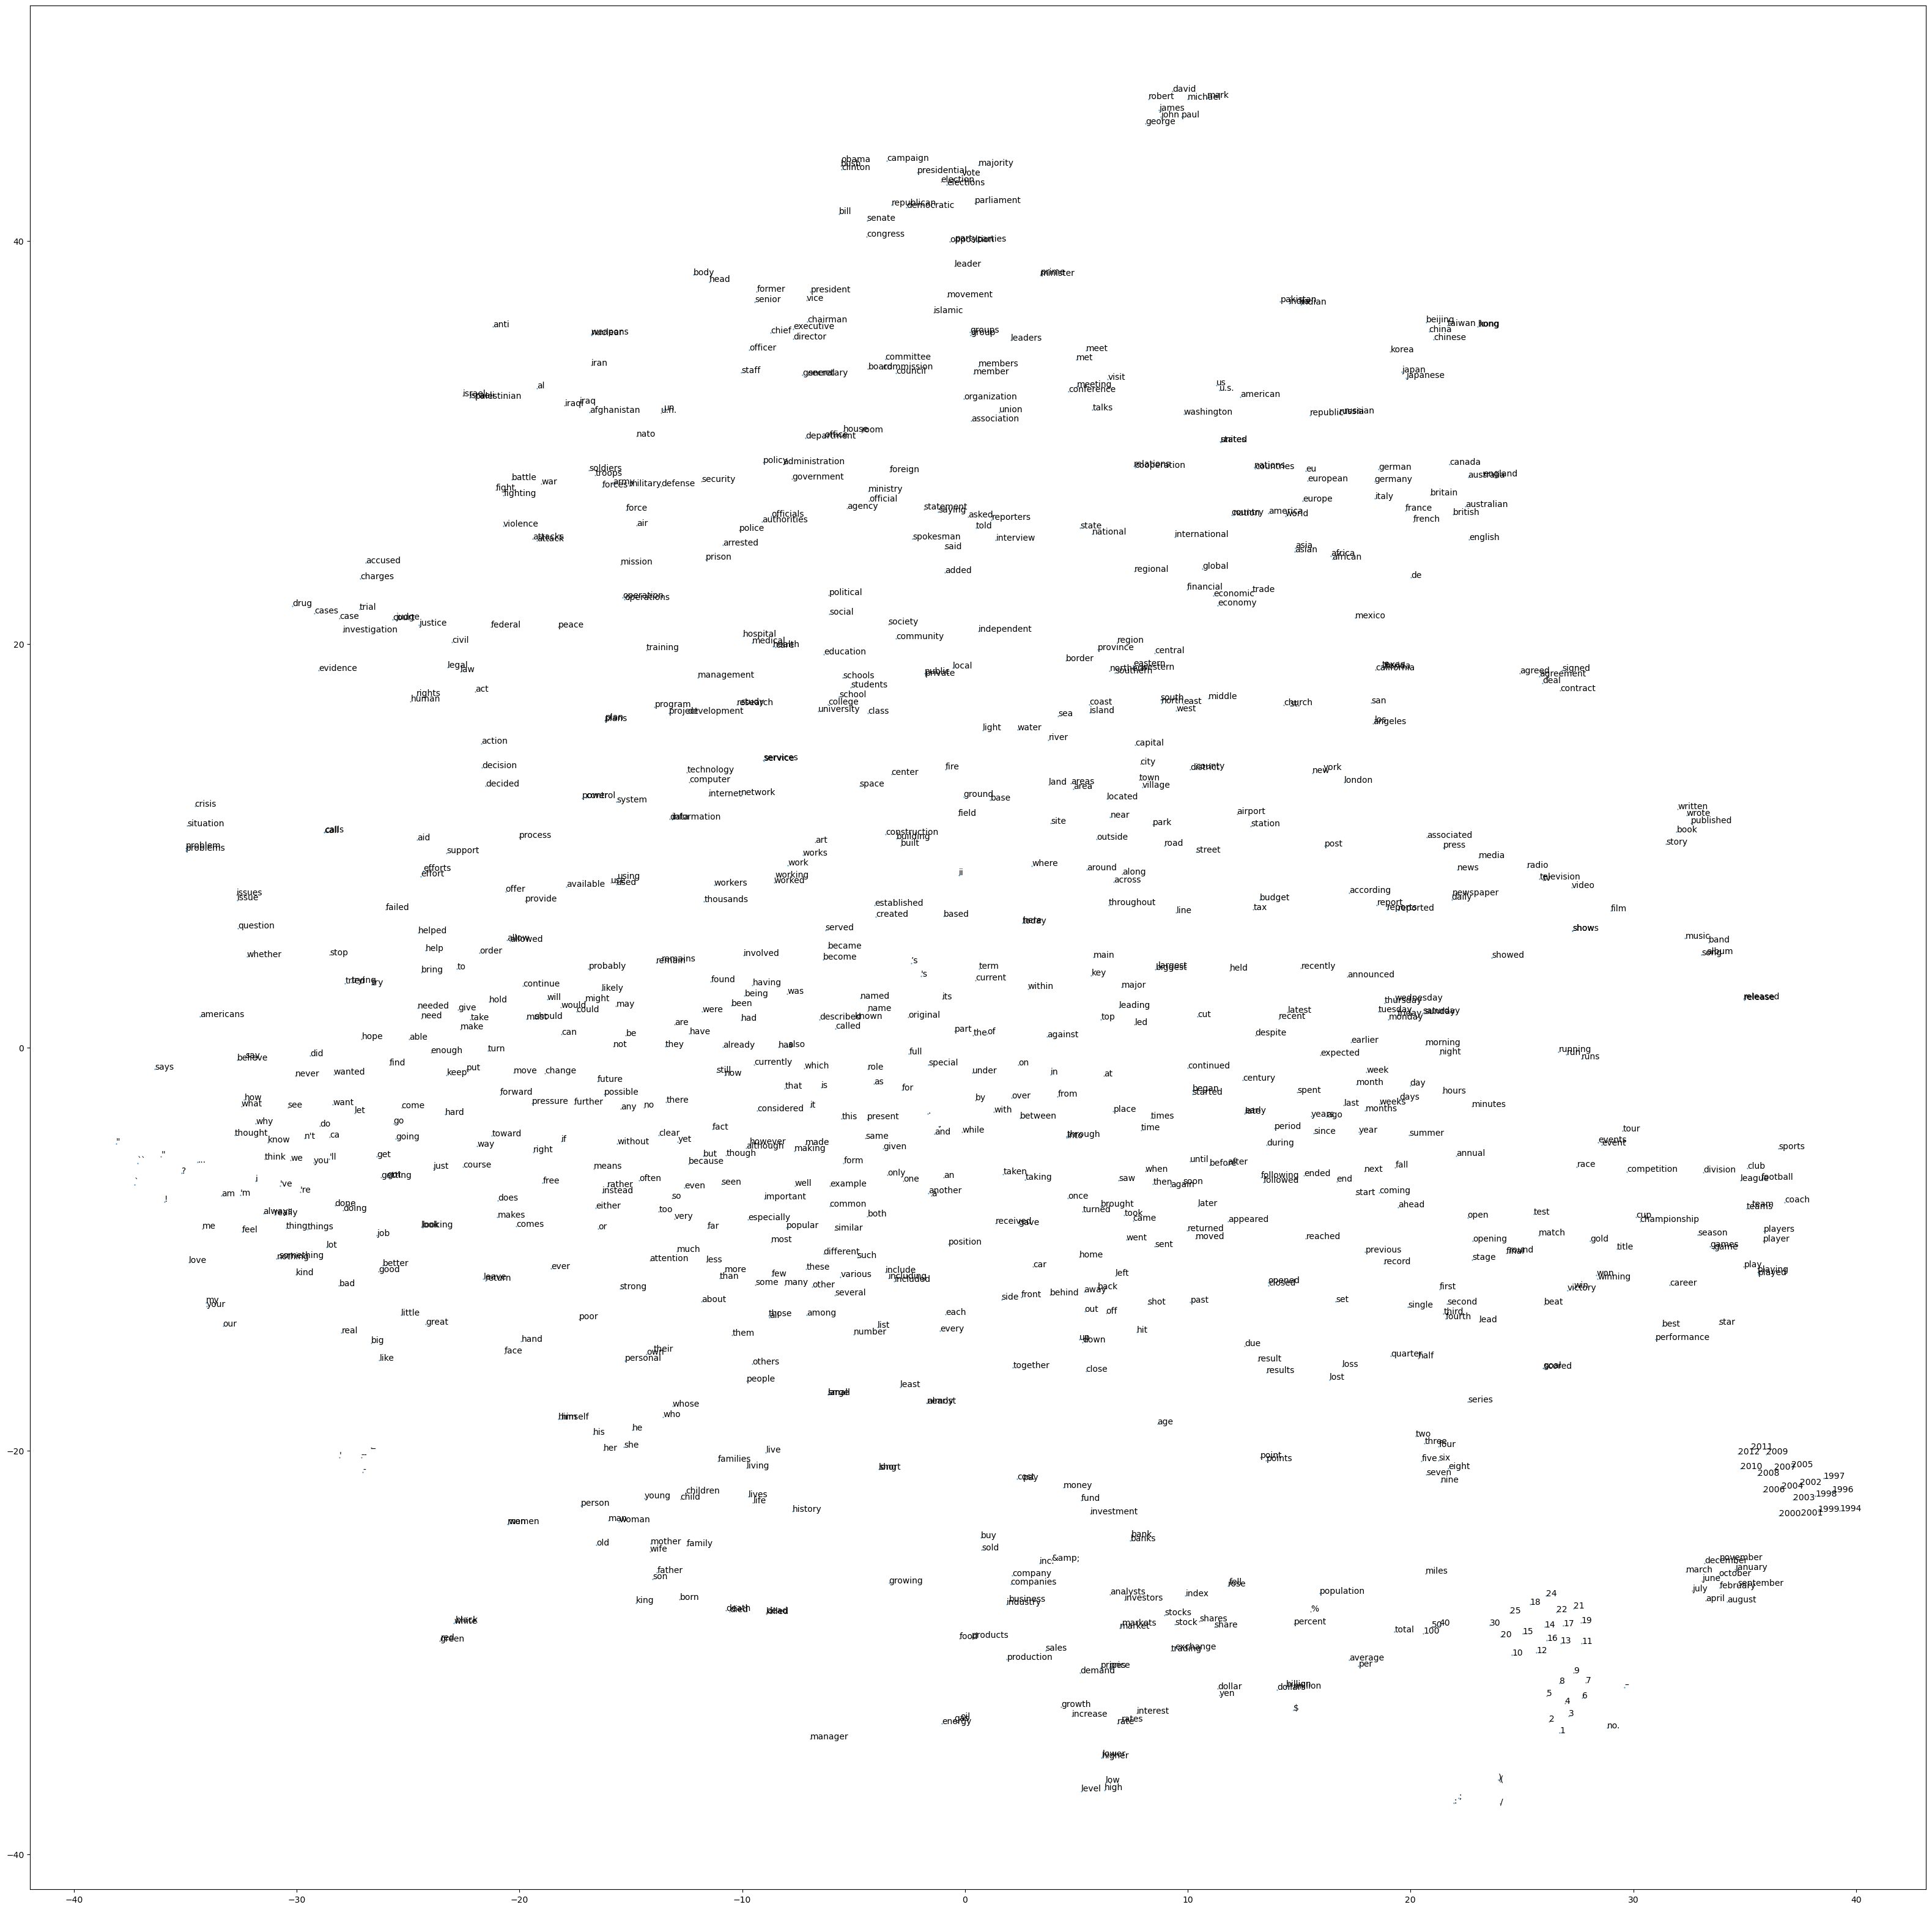

In [52]:
import matplotlib.pyplot as plt

plt.figure(figsize=(40, 40))
axis = plt.gca()
np.set_printoptions(suppress=True)
plt.scatter(word_emb_tsne[:, 0], word_emb_tsne[:, 1], marker=".", s=1)

for idx in range(1000):
    plt.annotate(inv_index[idx],
                 xy=(word_emb_tsne[idx, 0], word_emb_tsne[idx, 1]),
                 xytext=(0, 0), textcoords='offset points')
plt.savefig("tsne.png")
plt.show()

### Using pre-trained embeddings in our model

We want to use these pre-trained embeddings for transfer learning. This process is rather similar than transfer learning in image recognition: the features learnt on words might help us bootstrap the learning process, and increase performance if we don't have enough training data.

- We initialize embedding matrix from the model with Glove embeddings:
 - take all unique words from our BBC news dataset to build a vocabulary (`MAX_NB_WORDS = 20000`), and look up their Glove embedding 
 - place the Glove embedding at the corresponding index in the matrix
 - if the word is not in the Glove vocabulary, we only place zeros in the matrix

In [53]:
EMBEDDING_DIM = 100

# prepare embedding matrix
nb_words_in_matrix = 0
nb_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NB_WORDS:
        continue
    embedding_vector = get_emb(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector # Place the Glove embedding at the corresponding index in the matrix
        nb_words_in_matrix = nb_words_in_matrix + 1
        
print("added %d words in the embedding matrix" % nb_words_in_matrix)

added 17275 words in the embedding matrix


Build a layer with pre-trained embeddings:

In [54]:
pretrained_embedding_layer = Embedding(
    MAX_NB_WORDS, EMBEDDING_DIM,
    weights=[embedding_matrix],
    input_length=MAX_SEQUENCE_LENGTH,
)

/opt/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


### A model with pre-trained Embeddings

Now we can build a model with pre-trained embeddings. We will use the same architecture as before, but we will use the `pretrained_embedding_layer` as the first layer of the model.

In [55]:
model = Sequential([
    # Add the pre-defined and pre-trained embedding layer
    pretrained_embedding_layer,
    GlobalAveragePooling1D(),
    Dense(N_CLASSES, activation='softmax')
])

# Set the embedding layer's trainable attribute to False to not fine-tune the embeddings - you can try to change this
model.layers[0].trainable = False

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])


In [56]:
model.fit(x_train, y_train, validation_split=0.1,
          epochs=15, batch_size=32)

Epoch 1/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4137 - loss: 1.5146 - val_accuracy: 0.9064 - val_loss: 1.2081
Epoch 2/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8530 - loss: 1.1421 - val_accuracy: 0.8966 - val_loss: 0.9494
Epoch 3/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8931 - loss: 0.9020 - val_accuracy: 0.9212 - val_loss: 0.7805
Epoch 4/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9070 - loss: 0.7527 - val_accuracy: 0.9310 - val_loss: 0.6625
Epoch 5/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9161 - loss: 0.6420 - val_accuracy: 0.9360 - val_loss: 0.5814
Epoch 6/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9218 - loss: 0.5747 - val_accuracy: 0.9261 - val_loss: 0.5258
Epoch 7/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9316 - loss: 0.5147 - val_accuracy: 0.9360 - val_loss: 0.4757
Epoch 8/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9353 - loss: 0.4740 - val_accuracy: 0.9409 - val_loss:

### Reality check

On small/medium datasets (few 10,000s) of reasonably large documents (e.g. more than a few paragraphs), simpler classification methods usually perform better, and are much more efficient to train and use. Here are two resources to go further, if you are curious:
- Naive Bayes approach, using scikit-learn [http://scikit-learn.org/stable/datasets/twenty_newsgroups.html](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html)
- Alec Radford (OpenAI) gave a very interesting presentation, showing that you need a VERY large dataset to have real gains from GRU/LSTM in text classification [https://www.slideshare.net/odsc/alec-radfordodsc-presentation](https://www.slideshare.net/odsc/alec-radfordodsc-presentation)

Training deep architectures from random init on text classification is usually a waste of time.

However, when looking at features, one can see that classification using simple methods isn't very robust, and won't generalize well to slightly different domains (e.g. forum posts => emails)

Nowadays, the strategy would be to use pre-trained deep network (BERT) to extract features and fit a linear classifer on top of this. This is especially useful when classifying short texts (e.g. one or a few sentences) as this kind of tasks can be very sensitive to understanding the meaning resulting from intra-sentence interactions between words. The next session on attentional mechanisms and pre-trained transformer-based word models will explain this in more details.

### Bonus Task (Optional)

- The `Transformers` library from Hugging Face provides a very easy way to use pre-trained models for text classification. You can try to use it to classify the BBC dataset. Part of the code needed is provided below:

In [57]:
from transformers import BertTokenizer, TFBertForSequenceClassification

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5)

inputs = tokenizer(texts_train, return_tensors="tf", padding=True, truncation=True, max_length=100)
model_inputs = {key: val for key, val in inputs.items()}

# Fine-tune the model: the model is in the same format as our Keras models, so you can use the same methods to train it

RuntimeError: Failed to import transformers.models.bert.modeling_tf_bert because of the following error (look up to see its traceback):
Your currently installed version of Keras is Keras 3, but this is not yet supported in Transformers. Please install the backwards-compatible tf-keras package with `pip install tf-keras`.